In [2]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim as gensimvis 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from collections import Counter

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import word_tokenize

import random

import seaborn as sns
import matplotlib.colors as mcolors

# Prepare Data

In [3]:
reviews = pd.read_csv("Preprocessing_review_df.csv")
reviews.head()

,ReviewID,SKU,Star,Reviews
0,1,6047800,5,old missed actual photo cranking great quality...
1,2,6047800,5,cheaper buying instax cartridge cent selphy ce...
2,3,6047800,5,wife picture worry noisy employee getting phot...
3,4,6047800,5,east put together perfect size home room nicel...
4,5,6047800,5,product perfect recomendado buenas fotos gusta


In [3]:
reviews.shape

(860, 5)

In [4]:
products = pd.read_csv("Product_details.csv")
products.head()

,Unnamed: 0,ProductID,ProductName,Brand,Model,SKU,Price,Stars,TotalReviews
0,0,1,Canon - SELPHY CP1300 Wireless Compact Photo P...,Canon,2234C001,6047800,$129.99,4.6,"2,101"
1,1,2,HP - ENVY 6055e Wireless Inkjet Printer with 6...,HP,ENVY 6055e,6454281,$139.99,4.3,"3,022"
2,2,3,Epson - EcoTank ET-2850 All-in-One Cartridge-F...,Epson,C11CJ63202,6470013,$299.99,4.6,130
3,3,4,HP - OfficeJet Pro 8025e Wireless All-In-One I...,HP,OJP 8025e,6450663,$189.99,4.4,"3,389"
4,4,5,HP - DeskJet Plus 4140 Wireless All-In-One Ink...,HP,DesktJet Plus 4140,6485536,$109.99,4,13


In [5]:
brand=products[['SKU','Brand']]
brand.head()

,SKU,Brand
0,6047800,Canon
1,6454281,HP
2,6470013,Epson
3,6450663,HP
4,6485536,HP


In [43]:
brand.shape

(216, 2)

In [6]:
df = pd.merge(reviews, brand, on=["SKU"])
#reviews.merge(brand, on='SKU', how='left',indicator=True)
df.head()

,ReviewID,SKU,Star,Reviews,Brand
0,1,6047800,5,old missed actual photo cranking great quality...,Canon
1,1,6047800,5,old missed actual photo cranking great quality...,Canon
2,1,6047800,5,old missed actual photo cranking great quality...,Canon
3,2,6047800,5,cheaper buying instax cartridge cent selphy ce...,Canon
4,2,6047800,5,cheaper buying instax cartridge cent selphy ce...,Canon


In [7]:
df=df.drop_duplicates('ReviewID')
df.shape

(859, 5)

In [8]:
df.Brand.value_counts()

HP             392
Epson          187
Canon          160
Brother         60
New!HP          20
XYZprinting     20
Fujifilm        20
Name: Brand, dtype: int64

In [9]:
df.to_csv("df.csv", index=False)

In [10]:
good_review = df[(df["Star"]==5) | (df["Star"]==4)]
good_review.head()

,ReviewID,SKU,Star,Reviews,Brand
0,1,6047800,5,old missed actual photo cranking great quality...,Canon
3,2,6047800,5,cheaper buying instax cartridge cent selphy ce...,Canon
6,3,6047800,5,wife picture worry noisy employee getting phot...,Canon
9,4,6047800,5,east put together perfect size home room nicel...,Canon
12,5,6047800,5,product perfect recomendado buenas fotos gusta,Canon


In [11]:
good_review.to_csv("good_review.csv", index=False)

In [12]:
good_review.shape

(741, 5)

In [13]:
good_review.Brand.value_counts()

HP             313
Epson          168
Canon          151
Brother         58
New!HP          19
Fujifilm        19
XYZprinting     13
Name: Brand, dtype: int64

In [14]:
random.seed(3)
hp=good_review[(good_review['Brand']=='HP')|(good_review['Brand']=='New!HP')].sample(n=151)
canon=good_review[good_review['Brand']=='Canon']
print("HP: "+ str(hp.shape) +'\n'+ "canon: " + str(canon.shape))

HP: (151, 5)
canon: (151, 5)


# Word Frenquency and Word Cloud

In [15]:
def remove_cus(text):
    text_tokens = word_tokenize(text)
    cus_stop=['hp','canon']
    words = [word for word in text_tokens if not word in cus_stop]
    return words
import string
def remove_punctuation(text):
    no_punct=" ".join([str(c) for c in text if c not in string.punctuation])
    return no_punct

In [17]:
# HP Word Frenquency
string = " ".join(hp for hp in hp["Reviews"])
words_hp=string.split()
word_freq_hp=Counter(words_hp)
most_common_hp=word_freq_hp.most_common(20)
most_common_hp

[('app', 191),
 ('ink', 179),
 ('photo', 141),
 ('quality', 117),
 ('easy', 112),
 ('setup', 111),
 ('cartridge', 104),
 ('great', 97),
 ('color', 92),
 ('work', 88),
 ('phone', 82),
 ('scan', 81),
 ('smart', 79),
 ('feature', 79),
 ('home', 76),
 ('office', 75),
 ('device', 65),
 ('small', 63),
 ('picture', 62),
 ('scanning', 59)]

In [18]:
# Canon Word Frenquency
string_canon = " ".join(canon for canon in canon["Reviews"])
words_canon=string_canon.split()
word_freq_canon=Counter(words_canon)
most_common_canon=word_freq_canon.most_common(20)
most_common_canon

[('photo', 195),
 ('ink', 76),
 ('app', 72),
 ('great', 65),
 ('easy', 65),
 ('picture', 64),
 ('quality', 60),
 ('cartridge', 58),
 ('phone', 45),
 ('work', 44),
 ('selphy', 43),
 ('color', 37),
 ('setup', 33),
 ('size', 29),
 ('connect', 29),
 ('little', 27),
 ('product', 24),
 ('wifi', 24),
 ('looking', 23),
 ('sheet', 22)]

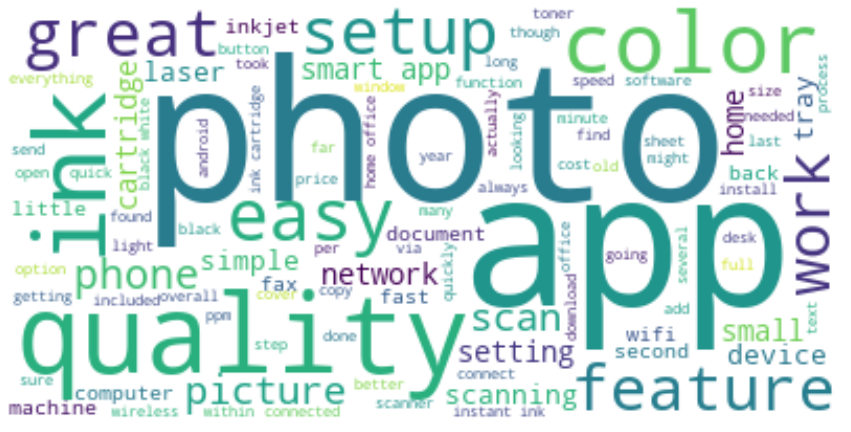

In [19]:
# Create word cloud of HP
wordcloud_hp = WordCloud(background_color="white", 
                              max_words=100, 
                             ).generate(string)

# view the wordcloud
plt.figure(figsize=(15,8) )
plt.imshow(wordcloud_hp, interpolation='bilinear')
plt.axis('off')
plt.show()

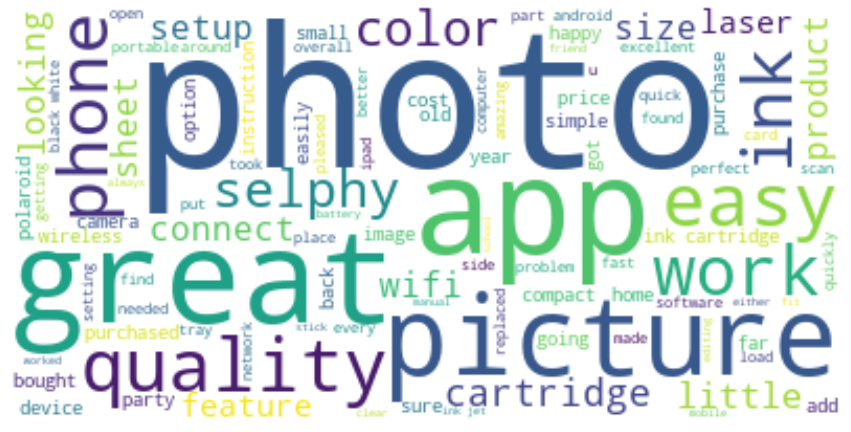

In [20]:
# Create word cloud of Canon
wordcloud_canon = WordCloud(background_color="white", 
                              max_words=100, 
                             ).generate(string_canon)

# view the wordcloud
plt.figure(figsize=(15,8) )
plt.imshow(wordcloud_canon, interpolation='bilinear')
plt.axis('off')
plt.show()

# Creating Bigram and Trigram Models

In [21]:
# Define functions for bigrams, trigrams
def bigram_model(words):
    model=gensim.models.Phrases(words, min_count=5, threshold=100)
    bigram=gensim.models.phrases.Phraser(model)
    return(bigram)

def trigram_model(bigram, words):
    model=gensim.models.Phrases(bigram[words], threshold=100)
    trigram=gensim.models.phrases.Phraser(model)
    return(bigram)    

def make_bigrams(bigram, texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(trigram, texts):
    return [trigram[bigram[doc]] for doc in texts]

In [22]:
# Create words list
data_hp = hp.Reviews.values.tolist()
words_hp = [elem.strip().split() for elem in data_hp]

In [23]:
# HP biagram and trigram model
bigram_hp=bigram_model(words_hp)
trigram_hp=trigram_model(bigram_hp, words_hp)
print(trigram_hp[bigram_hp[words_hp[0]]])

['always', 'wanted', 'laserjet', 'home', 'office', 'due', 'pricing', 'normally', 'opted', 'desk', 'jet', 'normally', 'decision', 'main', 'reason', 'number', 'inkjets', 'tend', 'significantly', 'cheaper', 'laserjets', 'number', 'general', 'consensus', 'thought', 'toner', 'cost', 'ink', 'whereas', 'hardly', 'case', 'tend', 'uninitiated', 'laserjet', 'mdwe', 'conundrum', 'solved', 'longer', 'vexing', 'economically', 'priced', 'whereas', 'toner', 'relative', 'respectively', 'priced', 'allows', 'access', 'instant', 'ink', 'program', 'program', 'cost', 'benefit', 'office', 'setting', 'manager', 'associate', 'spend', 'improving', 'business', 'squandered', 'ordering', 'supply', 'extended', 'year', 'warranty', 'nearly', 'large', 'thought', 'going', 'super', 'plus', 'large', 'eye', 'sore', 'con', 'bland', 'design', 'smaller', 'statue', 'however', 'cosmetic', 'design', 'vibe', 'early', 'tech', 'wise', 'delivers', 'larger', 'counter', 'part', 'home', 'office', 'wanted', 'run', 'small', 'office', '

In [24]:
# Form HP Bigrams
data_bigrams_hp = make_bigrams(bigram_hp, words_hp)
print(data_bigrams_hp[:1])

[['always', 'wanted', 'laserjet', 'home', 'office', 'due', 'pricing', 'normally', 'opted', 'desk', 'jet', 'normally', 'decision', 'main', 'reason', 'number', 'inkjets', 'tend', 'significantly', 'cheaper', 'laserjets', 'number', 'general', 'consensus', 'thought', 'toner', 'cost', 'ink', 'whereas', 'hardly', 'case', 'tend', 'uninitiated', 'laserjet', 'mdwe', 'conundrum', 'solved', 'longer', 'vexing', 'economically', 'priced', 'whereas', 'toner', 'relative', 'respectively', 'priced', 'allows', 'access', 'instant', 'ink', 'program', 'program', 'cost', 'benefit', 'office', 'setting', 'manager', 'associate', 'spend', 'improving', 'business', 'squandered', 'ordering', 'supply', 'extended', 'year', 'warranty', 'nearly', 'large', 'thought', 'going', 'super', 'plus', 'large', 'eye', 'sore', 'con', 'bland', 'design', 'smaller', 'statue', 'however', 'cosmetic', 'design', 'vibe', 'early', 'tech', 'wise', 'delivers', 'larger', 'counter', 'part', 'home', 'office', 'wanted', 'run', 'small', 'office', 

In [25]:
# Create words list
data_canon = canon.Reviews.values.tolist()
words_canon = [elem.strip().split() for elem in data_canon]

In [26]:
# Canon biagram and trigram model
bigram_canon=bigram_model(words_canon)
trigram_canon=trigram_model(bigram_canon, words_canon)
print(trigram_canon[bigram_canon[words_canon[0]]])

['old', 'missed', 'actual', 'photo', 'cranking', 'great', 'quality', 'shot', 'important', 'moment', 'brilliant', 'choice', 'treat']


In [27]:
# Form Canon Bigrams
data_bigrams_canon = make_bigrams(bigram_canon, words_canon)
print(data_bigrams_canon[:1])

[['old', 'missed', 'actual', 'photo', 'cranking', 'great', 'quality', 'shot', 'important', 'moment', 'brilliant', 'choice', 'treat']]


# Create the Dictionary and Corpus needed for Topic Modeling

In [28]:
# Create Dictionary for HP
id2word_hp = corpora.Dictionary(data_bigrams_hp)

# Create Corpus of 5 stars
texts_hp = data_bigrams_hp

# Term Document Frequency of 5 stars
corpus_hp = [id2word_hp.doc2bow(text) for text in texts_hp]

# View
print(corpus_hp[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 2), (72, 6), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 2), (108, 2), (109, 1), (110, 1)

In [29]:
# Create Dictionary for Canon
id2word_canon = corpora.Dictionary(data_bigrams_canon)

# Create Corpus of 5 stars
texts_canon = data_bigrams_canon

# Term Document Frequency of 5 stars
corpus_canon = [id2word_canon.doc2bow(text) for text in texts_canon]

# View
print(corpus_canon[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


# Building the Topic Model

In [31]:
# Build LDA model for HP
lda_model_hp = gensim.models.ldamodel.LdaModel(corpus=corpus_hp,
                                           id2word=id2word_hp,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics for HP
pprint(lda_model_hp.print_topics())
doc_lda_hp = lda_model_hp[corpus_hp]

[(0,
  '0.021*"office" + 0.013*"adf" + 0.011*"fax" + 0.010*"quality" + '
  '0.010*"going" + 0.009*"easy" + 0.009*"maybe" + 0.009*"buying" + 0.009*"ink" '
  '+ 0.009*"wifi"'),
 (1,
  '0.027*"ink" + 0.015*"fax" + 0.014*"scan" + 0.013*"home" + 0.012*"setting" + '
  '0.011*"scanning" + 0.011*"office" + 0.009*"app" + 0.009*"smart" + '
  '0.009*"machine"'),
 (2,
  '0.016*"sleep" + 0.011*"final" + 0.009*"button" + 0.008*"ghz" + '
  '0.008*"exception" + 0.007*"wet" + 0.007*"away" + 0.007*"user" + '
  '0.007*"however" + 0.007*"output"'),
 (3,
  '0.039*"photo" + 0.027*"app" + 0.025*"picture" + 0.020*"phone" + '
  '0.015*"feature" + 0.010*"device" + 0.010*"ink" + 0.008*"ar" + 0.007*"fun" + '
  '0.006*"great"'),
 (4,
  '0.011*"polaroid" + 0.010*"little" + 0.010*"pack" + 0.008*"zink" + '
  '0.008*"somewhat" + 0.006*"defective" + 0.006*"tone" + 0.006*"somewhere" + '
  '0.006*"selfies" + 0.006*"became"'),
 (5,
  '0.014*"mailed" + 0.008*"dollar" + 0.006*"pairing" + 0.004*"construction" + '
  '0.004*"t

In [32]:
# Build LDA model for Canon
lda_model_canon = gensim.models.ldamodel.LdaModel(corpus=corpus_canon,
                                           id2word=id2word_canon,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics for Canon
pprint(lda_model_canon.print_topics())
doc_lda_canon = lda_model_canon[corpus_canon]

[(0,
  '0.027*"cartridge" + 0.023*"download" + 0.018*"ink" + 0.014*"work" + '
  '0.013*"black_white" + 0.013*"purchased" + 0.013*"know" + 0.013*"laser" + '
  '0.012*"far" + 0.012*"create"'),
 (1,
  '0.026*"great" + 0.023*"quality" + 0.018*"side" + 0.016*"easy" + '
  '0.016*"price" + 0.015*"done" + 0.015*"color" + 0.014*"quick" + '
  '0.013*"simple" + 0.013*"blank"'),
 (2,
  '0.017*"perfect" + 0.017*"year" + 0.016*"cassette" + 0.014*"great" + '
  '0.013*"purchased" + 0.011*"selphy" + 0.011*"pleased" + 0.011*"basic" + '
  '0.011*"ink" + 0.011*"photo"'),
 (3,
  '0.032*"cartridge" + 0.019*"replaced" + 0.015*"document" + 0.013*"model" + '
  '0.012*"whole" + 0.012*"ever" + 0.010*"ipad" + 0.010*"year" + 0.010*"longer" '
  '+ 0.010*"laser"'),
 (4,
  '0.029*"smaller" + 0.017*"amazing" + 0.016*"message" + 0.016*"error" + '
  '0.014*"quality" + 0.014*"excellent" + 0.012*"tray" + 0.012*"yes" + '
  '0.012*"decent" + 0.011*"great"'),
 (5,
  '0.072*"photo" + 0.036*"selphy" + 0.021*"made" + 0.020*"car

# Compute Model Perplexity and Coherence Score and Visulization

In [33]:
# Compute Perplexity for HP
print('\nPerplexity: ', lda_model_hp.log_perplexity(corpus_hp))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 5 stars
coherence_model_lda_hp = CoherenceModel(model=lda_model_hp, texts=data_bigrams_hp, dictionary=id2word_hp, coherence='c_v')
coherence_lda_hp = coherence_model_lda_hp.get_coherence()
print('\nCoherence Score: ', coherence_lda_hp)


Perplexity:  -7.5436504848638375

Coherence Score:  0.3742507283400835


In [81]:
# Visualize the topics for HP
pyLDAvis.enable_notebook()
vis_hp = pyLDAvis.gensim.prepare(lda_model_hp, corpus_hp, id2word_hp)
vis_hp

C:\Users\Kangping\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.163317 -0.022632       1        1  43.261714
6     -0.139078  0.014686       2        1  15.193511
1     -0.147888  0.108621       3        1  13.900566
3     -0.065725 -0.199558       4        1  12.900603
0      0.005434  0.117960       5        1   6.377268
9      0.065890 -0.043663       6        1   3.324297
2      0.142529  0.019620       7        1   2.689396
4      0.086719 -0.009915       8        1   1.238200
8      0.112910  0.006517       9        1   0.641751
5      0.102526  0.008364      10        1   0.472694, topic_info=         Term        Freq       Total Category  logprob  loglift
176     photo  119.000000  119.000000  Default  30.0000  30.0000
178   picture   67.000000   67.000000  Default  29.0000  29.0000
72     office   60.000000   60.000000  Default  28.0000  28.0000
543       fax   51.000000   51.000000  Default  27.0000  27.0000
77      phone   76.000000   76.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
772      pair    0.264270    1.528305  Topic10  -5.4743   3.5995
242     light    0.192552   16.399753  Topic10  -5.7909   0.9098
422   storage    0.147101    1.368548  Topic10  -6.0602   3.1241
1026   weight    0.147079    2.316215  Topic10  -6.0603   2.5978
1289     word    0.147030    1.674827  Topic10  -6.0606   2.9216

[591 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
423       1  0.691608       ability
423       4  0.172902       ability
2298      6  0.521784  accompanying
2426      3  0.817717      activate
426       1  0.631427           add
...     ...       ...           ...
2026      6  0.849978        yellow
610       1  0.495709           yet
610       5  0.396567           yet
957       5  0.905237         yield
684       8  0.514865          zink

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 2, 4, 1, 10, 3, 5, 9, 6])

In [34]:
# Compute Perplexity for CANON
print('\nPerplexity: ', lda_model_canon.log_perplexity(corpus_canon))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 5 stars
coherence_model_lda_canon = CoherenceModel(model=lda_model_canon, texts=data_bigrams_canon, dictionary=id2word_canon, coherence='c_v')
coherence_lda_canon = coherence_model_lda_canon.get_coherence()
print('\nCoherence Score: ', coherence_lda_canon)


Perplexity:  -7.083198358235709

Coherence Score:  0.3435226473925675


In [82]:
# Visualize the topics for HP
pyLDAvis.enable_notebook()
vis_canon = pyLDAvis.gensim.prepare(lda_model_canon, corpus_canon, id2word_canon)
vis_canon

C:\Users\Kangping\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.072460  0.174056       1        1  30.491710
8      0.158646  0.096535       2        1  24.077426
2     -0.025595  0.035988       3        1   8.968674
1     -0.093258 -0.041435       4        1   8.852396
5      0.202128 -0.186918       5        1   7.985473
0     -0.080104  0.023908       6        1   7.775814
3     -0.131356 -0.055484       7        1   7.561891
4     -0.042050 -0.007928       8        1   2.538629
7     -0.045809 -0.020228       9        1   1.264773
6     -0.015062 -0.018493      10        1   0.483215, topic_info=          Term        Freq       Total Category  logprob  loglift
9        photo  177.000000  177.000000  Default  30.0000  30.0000
14   cartridge   54.000000   54.000000  Default  29.0000  29.0000
26     picture   48.000000   48.000000  Default  28.0000  28.0000
20      selphy   42.000000   42.000000  Default  27.0000  27.0000
10     quality   50.000000   50.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
42     perfect    0.015735   12.047036  Topic10  -7.4120  -1.3082
273       year    0.015735   13.272836  Topic10  -7.4121  -1.4051
314      every    0.015735   10.245875  Topic10  -7.4121  -1.1463
61         got    0.015735    9.824921  Topic10  -7.4121  -1.1043
43       phone    0.015734   39.027463  Topic10  -7.4121  -2.4837

[535 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.978101      actual
1329      5  0.742230     adaptor
280       1  0.578162         add
280       2  0.449682         add
557       6  0.972924  additional
...     ...       ...         ...
273       4  0.075342        year
273       7  0.301367        year
770       4  0.810358      yellow
889       8  0.912755         yes
74        7  0.598018          yr

[691 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 3, 2, 6, 1, 4, 5, 8, 7])

# Building LDA Mallet Model

In [35]:
# import mallet
import os
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'

In [36]:
# hp
ldamallet_hp = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_hp, num_topics=10, id2word=id2word_hp)
# Show Topics
pprint(ldamallet_hp.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet_hp = CoherenceModel(model=ldamallet_hp, texts=data_bigrams_hp, dictionary=id2word_hp, coherence='c_v')
coherence_ldamallet_hp = coherence_model_ldamallet_hp.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_hp)

[(0,
  [('app', 0.11190053285968028),
   ('great', 0.04884547069271759),
   ('smart', 0.04884547069271759),
   ('instant', 0.027531083481349913),
   ('wireless', 0.02664298401420959),
   ('ink', 0.02664298401420959),
   ('year', 0.020426287744227355),
   ('desk', 0.017761989342806393),
   ('top', 0.016873889875666074),
   ('download', 0.013321492007104795)]),
 (1,
  [('color', 0.05381944444444445),
   ('quality', 0.04774305555555555),
   ('copy', 0.041666666666666664),
   ('button', 0.03125),
   ('scanner', 0.030381944444444444),
   ('text', 0.0234375),
   ('open', 0.019965277777777776),
   ('cover', 0.019097222222222224),
   ('design', 0.017361111111111112),
   ('screen', 0.015625)]),
 (2,
  [('computer', 0.04271548436308162),
   ('setup', 0.04271548436308162),
   ('network', 0.03966437833714721),
   ('laser', 0.03585049580472922),
   ('process', 0.02517162471395881),
   ('connected', 0.02517162471395881),
   ('inkjet', 0.020594965675057208),
   ('install', 0.019832189168573607),
   (

In [37]:
# Canon
ldamallet_canon = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_canon, num_topics=10, id2word=id2word_canon)
# Show Topics
pprint(ldamallet_canon.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet_canon = CoherenceModel(model=ldamallet_canon, texts=data_bigrams_canon, dictionary=id2word_canon, coherence='c_v')
coherence_ldamallet_canon = coherence_model_ldamallet_canon.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_canon)

[(0,
  [('open', 0.03694581280788178),
   ('home', 0.03694581280788178),
   ('setup', 0.034482758620689655),
   ('party', 0.034482758620689655),
   ('size', 0.03201970443349754),
   ('ipad', 0.03201970443349754),
   ('find', 0.03201970443349754),
   ('load', 0.029556650246305417),
   ('place', 0.029556650246305417),
   ('door', 0.019704433497536946)]),
 (1,
  [('wifi', 0.05227272727272727),
   ('feature', 0.05),
   ('simple', 0.038636363636363635),
   ('setup', 0.038636363636363635),
   ('easily', 0.03636363636363636),
   ('instruction', 0.031818181818181815),
   ('perfect', 0.029545454545454545),
   ('connect', 0.025),
   ('part', 0.022727272727272728),
   ('fast', 0.022727272727272728)]),
 (2,
  [('photo', 0.2817919075144509),
   ('phone', 0.036127167630057806),
   ('app', 0.030346820809248554),
   ('sheet', 0.024566473988439308),
   ('option', 0.02167630057803468),
   ('add', 0.02167630057803468),
   ('small', 0.02023121387283237),
   ('usb', 0.015895953757225433),
   ('layout', 0.0

# Find the optimal number of topics for LDA

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# HP Can take a long time to run.
model_list_hp, coherence_values_hp = compute_coherence_values(dictionary=id2word_hp, corpus=corpus_hp, texts=data_bigrams_hp, start=2, limit=40, step=6)

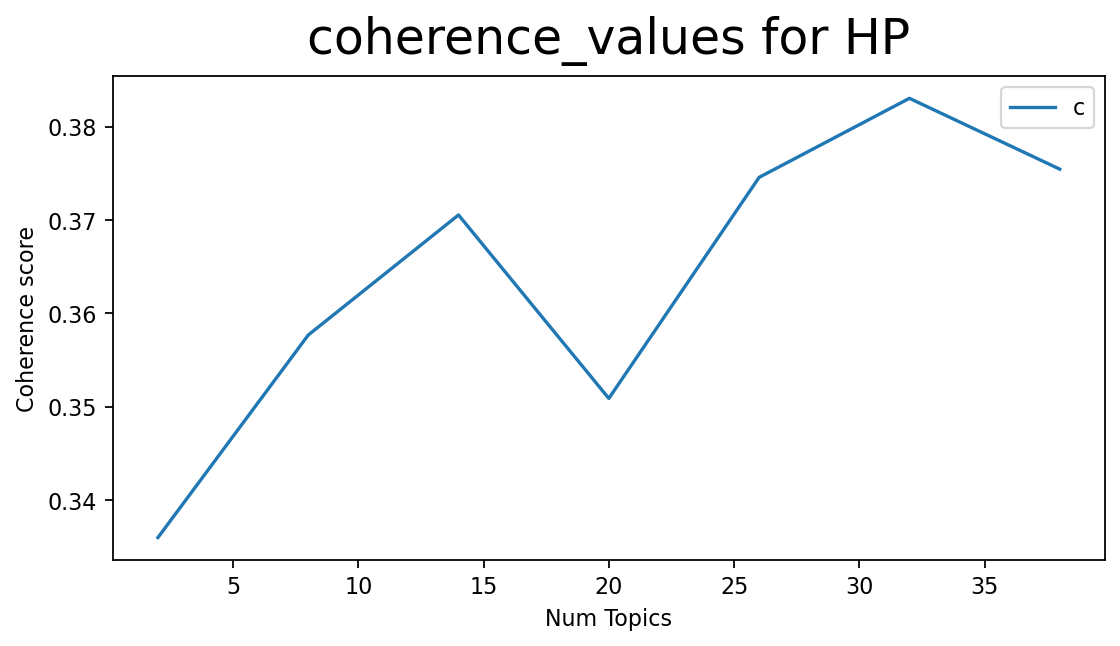

In [84]:
# Show graph for HP
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(8,4), dpi=160)
plt.plot(x, coherence_values_hp)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for HP"), loc='best')
plt.title('coherence_values for HP', fontdict=dict(size=22),y=1.02)
plt.show()

In [41]:
# Print the coherence scores for hp
for m, cv in zip(x, coherence_values_hp):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.336
Num Topics = 8  has Coherence Value of 0.3577
Num Topics = 14  has Coherence Value of 0.3705
Num Topics = 20  has Coherence Value of 0.3509
Num Topics = 26  has Coherence Value of 0.3746
Num Topics = 32  has Coherence Value of 0.383
Num Topics = 38  has Coherence Value of 0.3754


In [42]:
# Select the model and print the topics for HP
optimal_model_hp = model_list_hp[5]
model_topics_hp = optimal_model_hp.show_topics(formatted=False)
pprint(optimal_model_hp.print_topics(num_words=10))

[(16,
  '0.304*"app" + 0.075*"phone" + 0.064*"size" + 0.059*"download" + 0.042*"add" '
  '+ 0.033*"item" + 0.031*"made" + 0.021*"wanted" + 0.021*"select" + '
  '0.017*"bluetooth"'),
 (18,
  '0.102*"smart" + 0.055*"install" + 0.040*"volume" + 0.040*"year" + '
  '0.040*"expensive" + 0.036*"worth" + 0.036*"honestly" + 0.026*"area" + '
  '0.026*"simply" + 0.026*"money"'),
 (24,
  '0.137*"smart" + 0.062*"user" + 0.054*"computer" + 0.054*"year" + '
  '0.040*"black_white" + 0.038*"required" + 0.038*"wireless" + 0.035*"crisp" + '
  '0.024*"light" + 0.022*"warranty"'),
 (2,
  '0.161*"feature" + 0.052*"found" + 0.042*"full" + 0.042*"unit" + '
  '0.039*"single" + 0.034*"image" + 0.031*"sprocket" + 0.031*"detail" + '
  '0.023*"task" + 0.021*"content"'),
 (0,
  '0.141*"quality" + 0.081*"network" + 0.060*"find" + 0.060*"great" + '
  '0.045*"excellent" + 0.042*"clear" + 0.036*"minute" + 0.030*"worked" + '
  '0.030*"copying" + 0.030*"place"'),
 (23,
  '0.091*"color" + 0.046*"open" + 0.046*"copy" + 0.0

In [43]:
# CANON Can take a long time to run.
model_list_canon, coherence_values_canon = compute_coherence_values(dictionary=id2word_canon, corpus=corpus_canon, texts=data_bigrams_canon, start=2, limit=40, step=6)

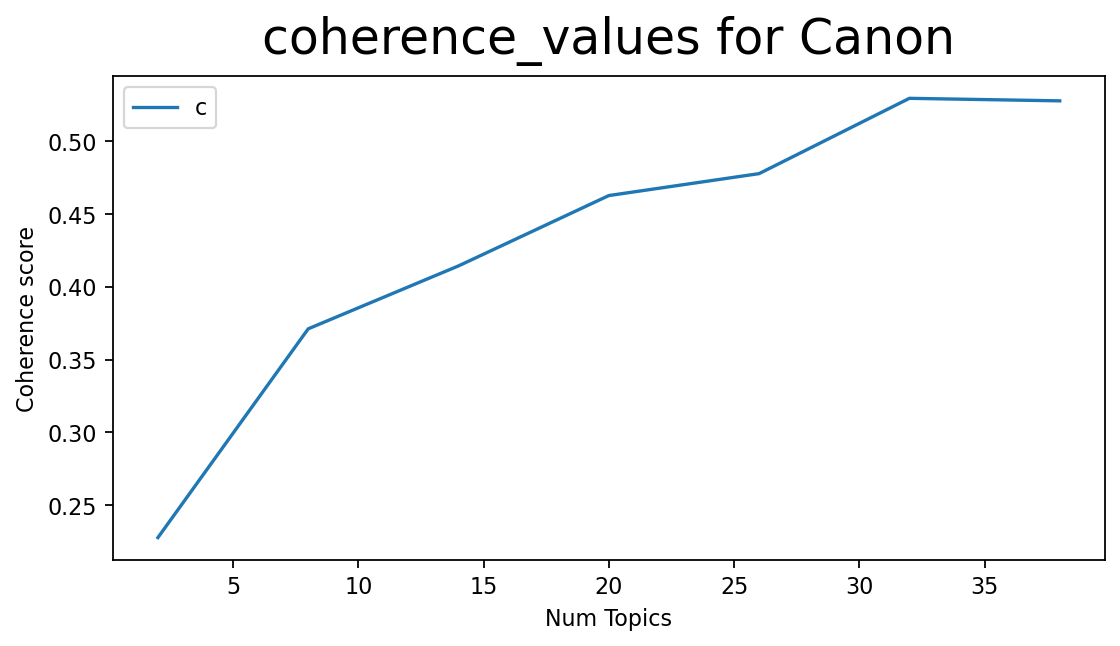

In [83]:
# Show graph for CANON
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(8,4), dpi=160)
plt.plot(x, coherence_values_canon)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for CANON"), loc='best')
plt.title('coherence_values for Canon', fontdict=dict(size=22),y=1.02)
plt.show()

In [45]:
# Print the coherence scores for canon
for m, cv in zip(x, coherence_values_canon):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2275
Num Topics = 8  has Coherence Value of 0.3711
Num Topics = 14  has Coherence Value of 0.4144
Num Topics = 20  has Coherence Value of 0.4628
Num Topics = 26  has Coherence Value of 0.4779
Num Topics = 32  has Coherence Value of 0.5297
Num Topics = 38  has Coherence Value of 0.5279


In [46]:
# Select the model and print the topics for canon
optimal_model_canon = model_list_canon[5]
model_topics_canon = optimal_model_canon.show_topics(formatted=False)
pprint(optimal_model_canon.print_topics(num_words=10))

[(12,
  '0.082*"problem" + 0.059*"cartridge" + 0.041*"instruction" + 0.041*"super" + '
  '0.035*"shot" + 0.029*"scanned" + 0.024*"long" + 0.024*"turn" + '
  '0.024*"change" + 0.024*"business"'),
 (1,
  '0.434*"easy" + 0.048*"quickly" + 0.028*"putting" + 0.028*"ice" + '
  '0.028*"multiple" + 0.021*"setup" + 0.021*"code" + 0.014*"shade" + '
  '0.014*"woth" + 0.014*"book"'),
 (20,
  '0.159*"purchase" + 0.088*"black_white" + 0.071*"wanted" + 0.062*"black" + '
  '0.053*"worry" + 0.044*"setting" + 0.035*"disappoint" + 0.027*"real" + '
  '0.027*"highly" + 0.018*"employee"'),
 (16,
  '0.121*"ink" + 0.073*"selphy" + 0.073*"fit" + 0.048*"find" + 0.040*"special" '
  '+ 0.032*"clear" + 0.032*"glossy" + 0.032*"standard" + 0.024*"opened" + '
  '0.016*"delivers"'),
 (28,
  '0.189*"app" + 0.169*"selphy" + 0.080*"size" + 0.055*"layout" + 0.030*"qx" + '
  '0.030*"loading" + 0.030*"feel" + 0.030*"border" + 0.025*"run" + 0.020*"qr"'),
 (24,
  '0.137*"cost" + 0.069*"home" + 0.061*"worked" + 0.053*"install"

# Finding the dominant topic in each sentence

In [47]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [51]:
# HP
df_topic_sents_keywords_hp = format_topics_sentences(ldamodel=optimal_model_hp, corpus=corpus_hp, texts=data_hp)

# Format
df_dominant_topic_hp = df_topic_sents_keywords_hp.reset_index()
df_dominant_topic_hp.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_hp.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.1218,"toner, office, home, business, capability, mon...",always wanted laserjet home office due pricing...
1,1,13.0,0.1154,"document, copy, fast, double_sided, level, sid...",excellent copy scan bought replace copy machin...
2,2,25.0,0.1307,"minute, option, case, fairly, start, ready, ad...",little help social medium post physical app fa...
3,3,16.0,0.0631,"app, phone, size, download, add, item, made, w...",beautiful low profile space saver functional a...
4,4,20.0,0.1240,"easy, fast, design, jet, con, price, interface...",easy easy setup multifunction great home ink i...


In [50]:
# CANON
df_topic_sents_keywords_canon = format_topics_sentences(ldamodel=optimal_model_canon, corpus=corpus_canon, texts=data_canon)

# Format
df_dominant_topic_canon = df_topic_sents_keywords_canon.reset_index()
df_dominant_topic_canon.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_canon.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.0879,"quality, back, put, produce, actual, red, disa...",old missed actual photo cranking great quality...
1,1,8.0,0.0723,"cartridge, amazing, sample, stop, interface, d...",cheaper buying instax cartridge cent selphy ce...
2,2,20.0,0.0781,"purchase, black_white, wanted, black, worry, s...",wife picture worry noisy employee getting phot...
3,3,26.0,0.0618,"simple, perfect, product, network, film, easil...",east put together perfect size home room nicel...
4,4,13.0,0.0616,"card, friend, price, iphone, enjoying, family,...",product perfect recomendado buenas fotos gusta


# Find the most representative document for each topic

In [53]:
# HP Group top 5 sentences under each topic
sent_topics_sorteddf_mallet_hp = pd.DataFrame()

sent_topics_outdf_grpd_hp = df_topic_sents_keywords_hp.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_hp:
    sent_topics_sorteddf_mallet_hp = pd.concat([sent_topics_sorteddf_mallet_hp, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet_hp.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_hp.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet_hp.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2210,"quality, network, find, great, excellent, clea...",exception proe excellent choice scanning copyi...
1,1.0,0.1633,"scanner, setting, work, option, support, windo...",feature rich compact fast quality awesome shar...
2,2.0,0.1687,"feature, found, full, unit, single, image, spr...",needed quality lower cost quick around house n...
3,3.0,0.3068,"tray, sheet, simple, line, network, cartridge,...",older brother laser starting sound funny decid...
4,4.0,0.2503,"connected, included, connection, laserjet, sof...",laser several advantage inkjet certain advanta...


In [54]:
# CANON Group top 5 sentences under each topic
sent_topics_sorteddf_mallet_canon = pd.DataFrame()

sent_topics_outdf_grpd_canon = df_topic_sents_keywords_canon.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_canon:
    sent_topics_sorteddf_mallet_canon = pd.concat([sent_topics_sorteddf_mallet_canon, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
canon
# Reset Index    
sent_topics_sorteddf_mallet_canon.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet_canon.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet_canon.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2494,"quick, software, recommend, small, line, offic...",little amazing quick phone photo paragliding s...
1,1.0,0.0887,"easy, quickly, putting, ice, multiple, setup, ...",refrigerator however ice maker making ice call...
2,2.0,0.3416,"cartridge, replaced, document, model, price, i...",relative fast compact scanner copier side conn...
3,3.0,0.2766,"party, ivy, point, answer, share, mini, carry,...",party whaaat party include celebration reunion...
4,4.0,0.0821,"phone, app, camera, android, mobile, process, ...",old rated google tried pre black friday purcha...


# Topic distribution across documents

In [55]:
# HP
# Number of Documents for Each Topic
topic_counts_hp = df_topic_sents_keywords_hp['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_hp = round(topic_counts_hp/topic_counts_hp.sum(), 4)

# Topic Number and Keywords
topic_num_keywords_hp = df_topic_sents_keywords_hp[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics_hp = pd.concat([topic_num_keywords_hp, topic_counts_hp, topic_contribution_hp], axis=1)

# Change Column names
df_dominant_topics_hp.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_hp.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,12.0,"toner, office, home, business, capability, mon...",7.0,0.0464
1.0,13.0,"document, copy, fast, double_sided, level, sid...",2.0,0.0132
2.0,25.0,"minute, option, case, fairly, start, ready, ad...",1.0,0.0066
3.0,16.0,"app, phone, size, download, add, item, made, w...",7.0,0.0464
4.0,20.0,"easy, fast, design, jet, con, price, interface...",2.0,0.0132


In [56]:
# CANON
# Number of Documents for Each Topic
topic_counts_canon = df_topic_sents_keywords_canon['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_canon = round(topic_counts_canon/topic_counts_canon.sum(), 4)

# Topic Number and Keywords
topic_num_keywords_canon = df_topic_sents_keywords_canon[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics_canon = pd.concat([topic_num_keywords_canon, topic_counts_canon, topic_contribution_canon], axis=1)

# Change Column names
df_dominant_topics_canon.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_canon.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,11.0,"quality, back, put, produce, actual, red, disa...",4.0,0.0265
1.0,8.0,"cartridge, amazing, sample, stop, interface, d...",11.0,0.0728
2.0,20.0,"purchase, black_white, wanted, black, worry, s...",5.0,0.0331
3.0,26.0,"simple, perfect, product, network, film, easil...",5.0,0.0331
4.0,13.0,"card, friend, price, iphone, enjoying, family,...",2.0,0.0132


# HP Frequency Distribution in Document and Each Topic

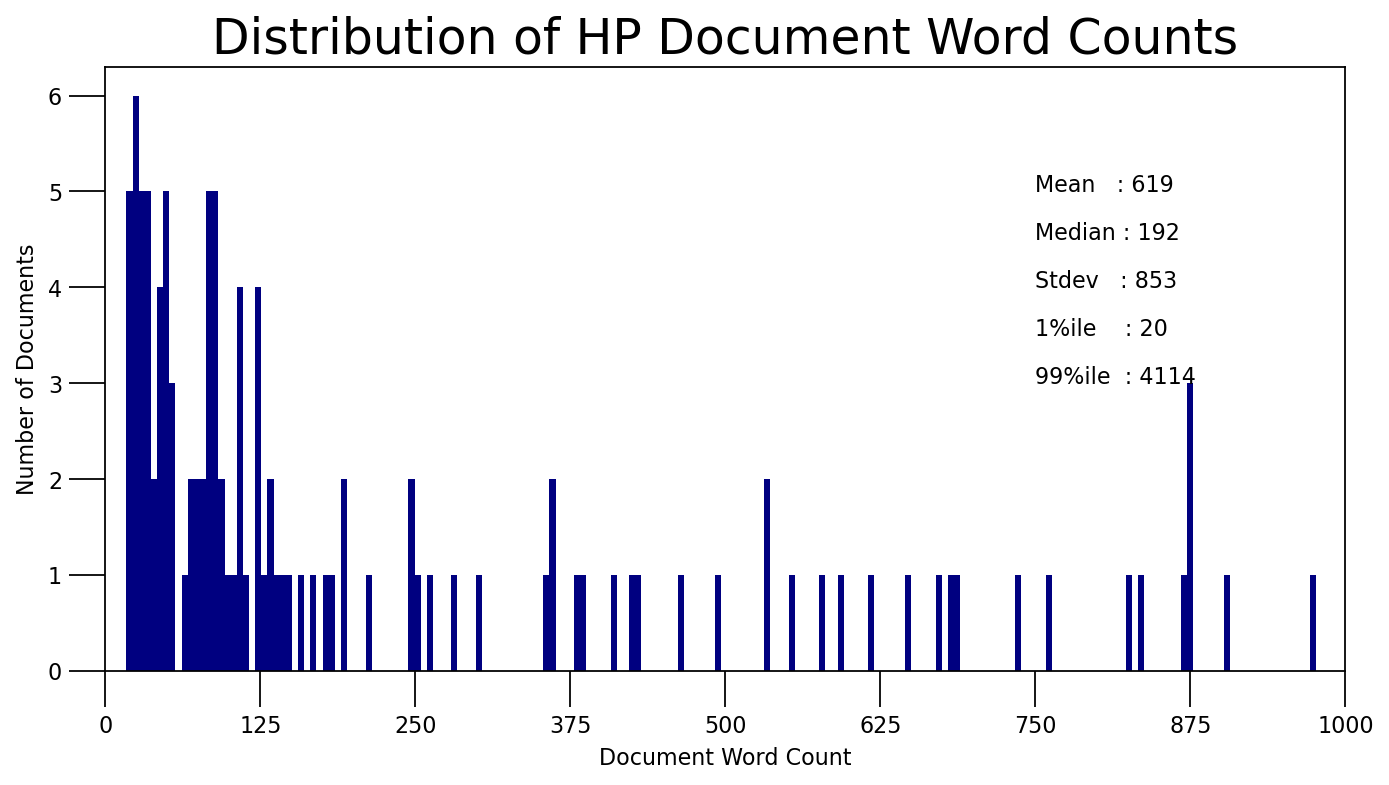

In [85]:
doc_lens_hp = [len(d) for d in df_dominant_topic_hp.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens_hp, bins = 1000, color='navy')
plt.text(750, 5, "Mean   : " + str(round(np.mean(doc_lens_hp))))
plt.text(750, 4.5, "Median : " + str(round(np.median(doc_lens_hp))))
plt.text(750, 4, "Stdev   : " + str(round(np.std(doc_lens_hp))))
plt.text(750, 3.5, "1%ile    : " + str(round(np.quantile(doc_lens_hp, q=0.01))))
plt.text(750, 3, "99%ile  : " + str(round(np.quantile(doc_lens_hp, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of HP Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\Kangping\AppData\Local\Temp/ipykernel_11168/3277624657.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_hp.loc[df_hp.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


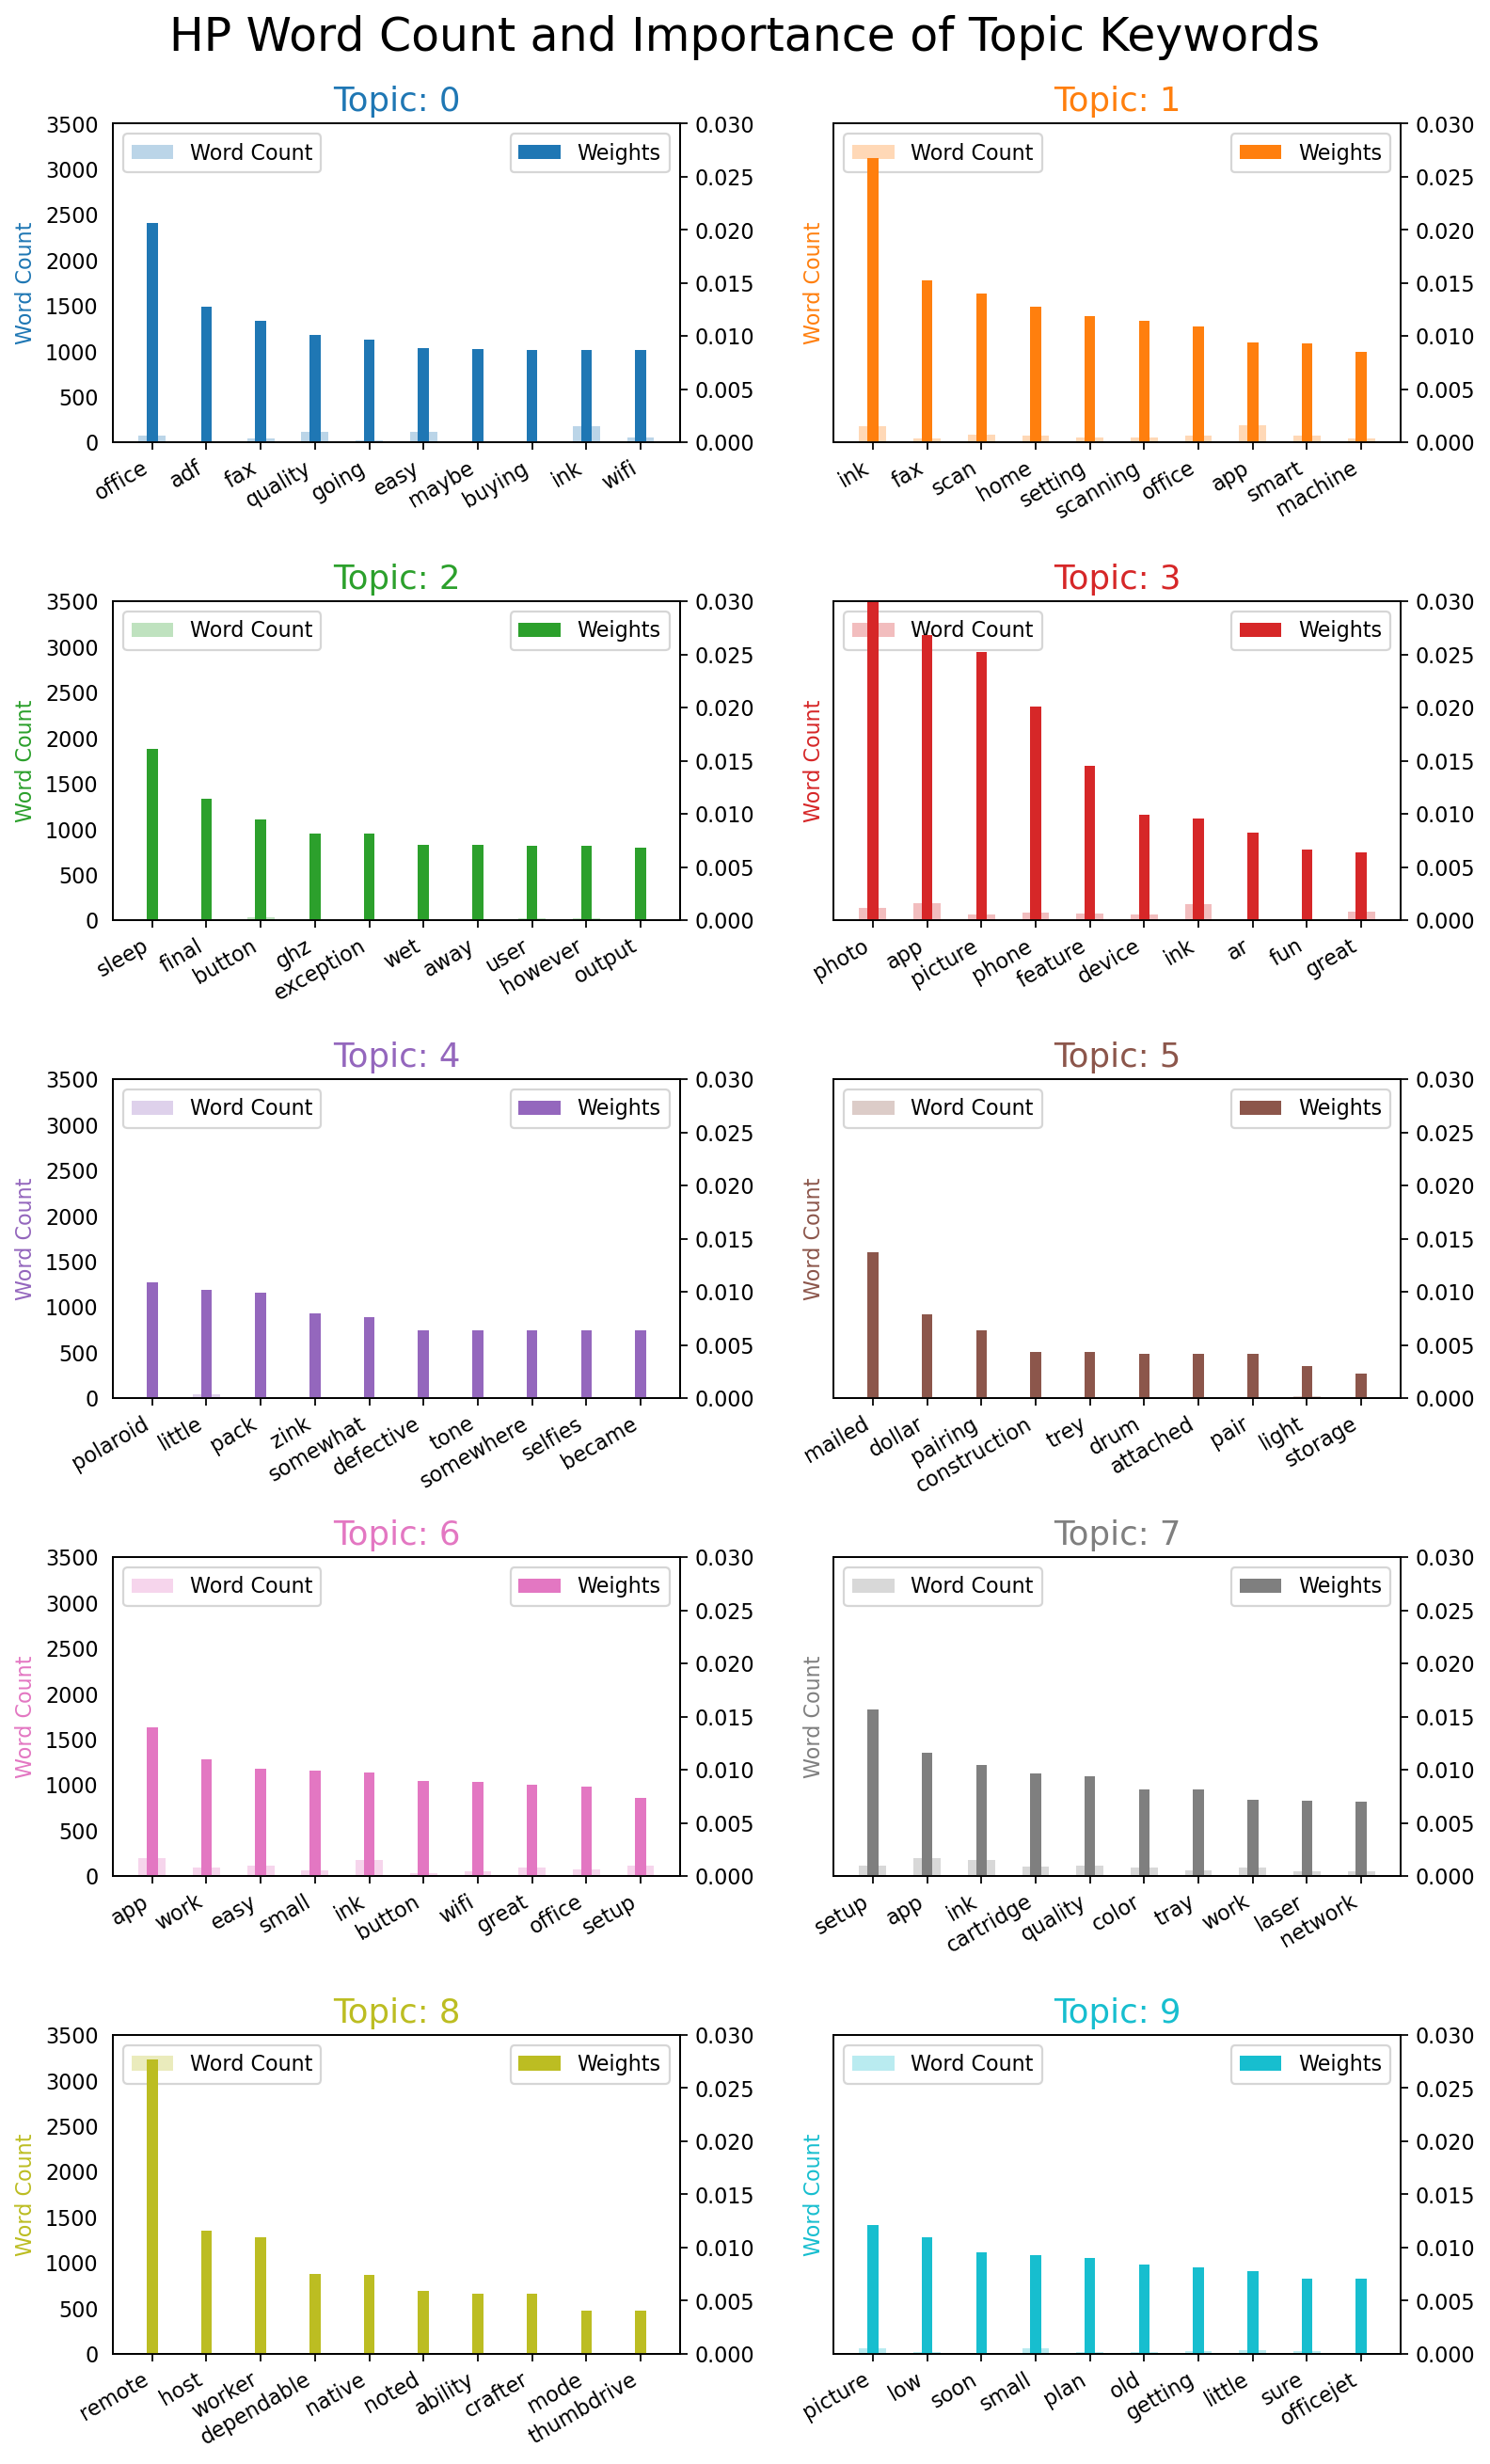

In [88]:
from collections import Counter
topics_hp = lda_model_hp.show_topics(formatted=False)
data_flat_hp = [w for w_list in words_hp for w in w_list]
counter_hp = Counter(data_flat_hp)

out = []
for i, topic in topics_hp:
    for word, weight in topic:
        out.append([word, i , weight, counter_hp[word]])

df_hp = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_hp.loc[df_hp.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_hp.loc[df_hp.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_hp.loc[df_hp.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('HP Word Count and Importance of Topic Keywords', fontsize=22, y=1.02)    
plt.show()

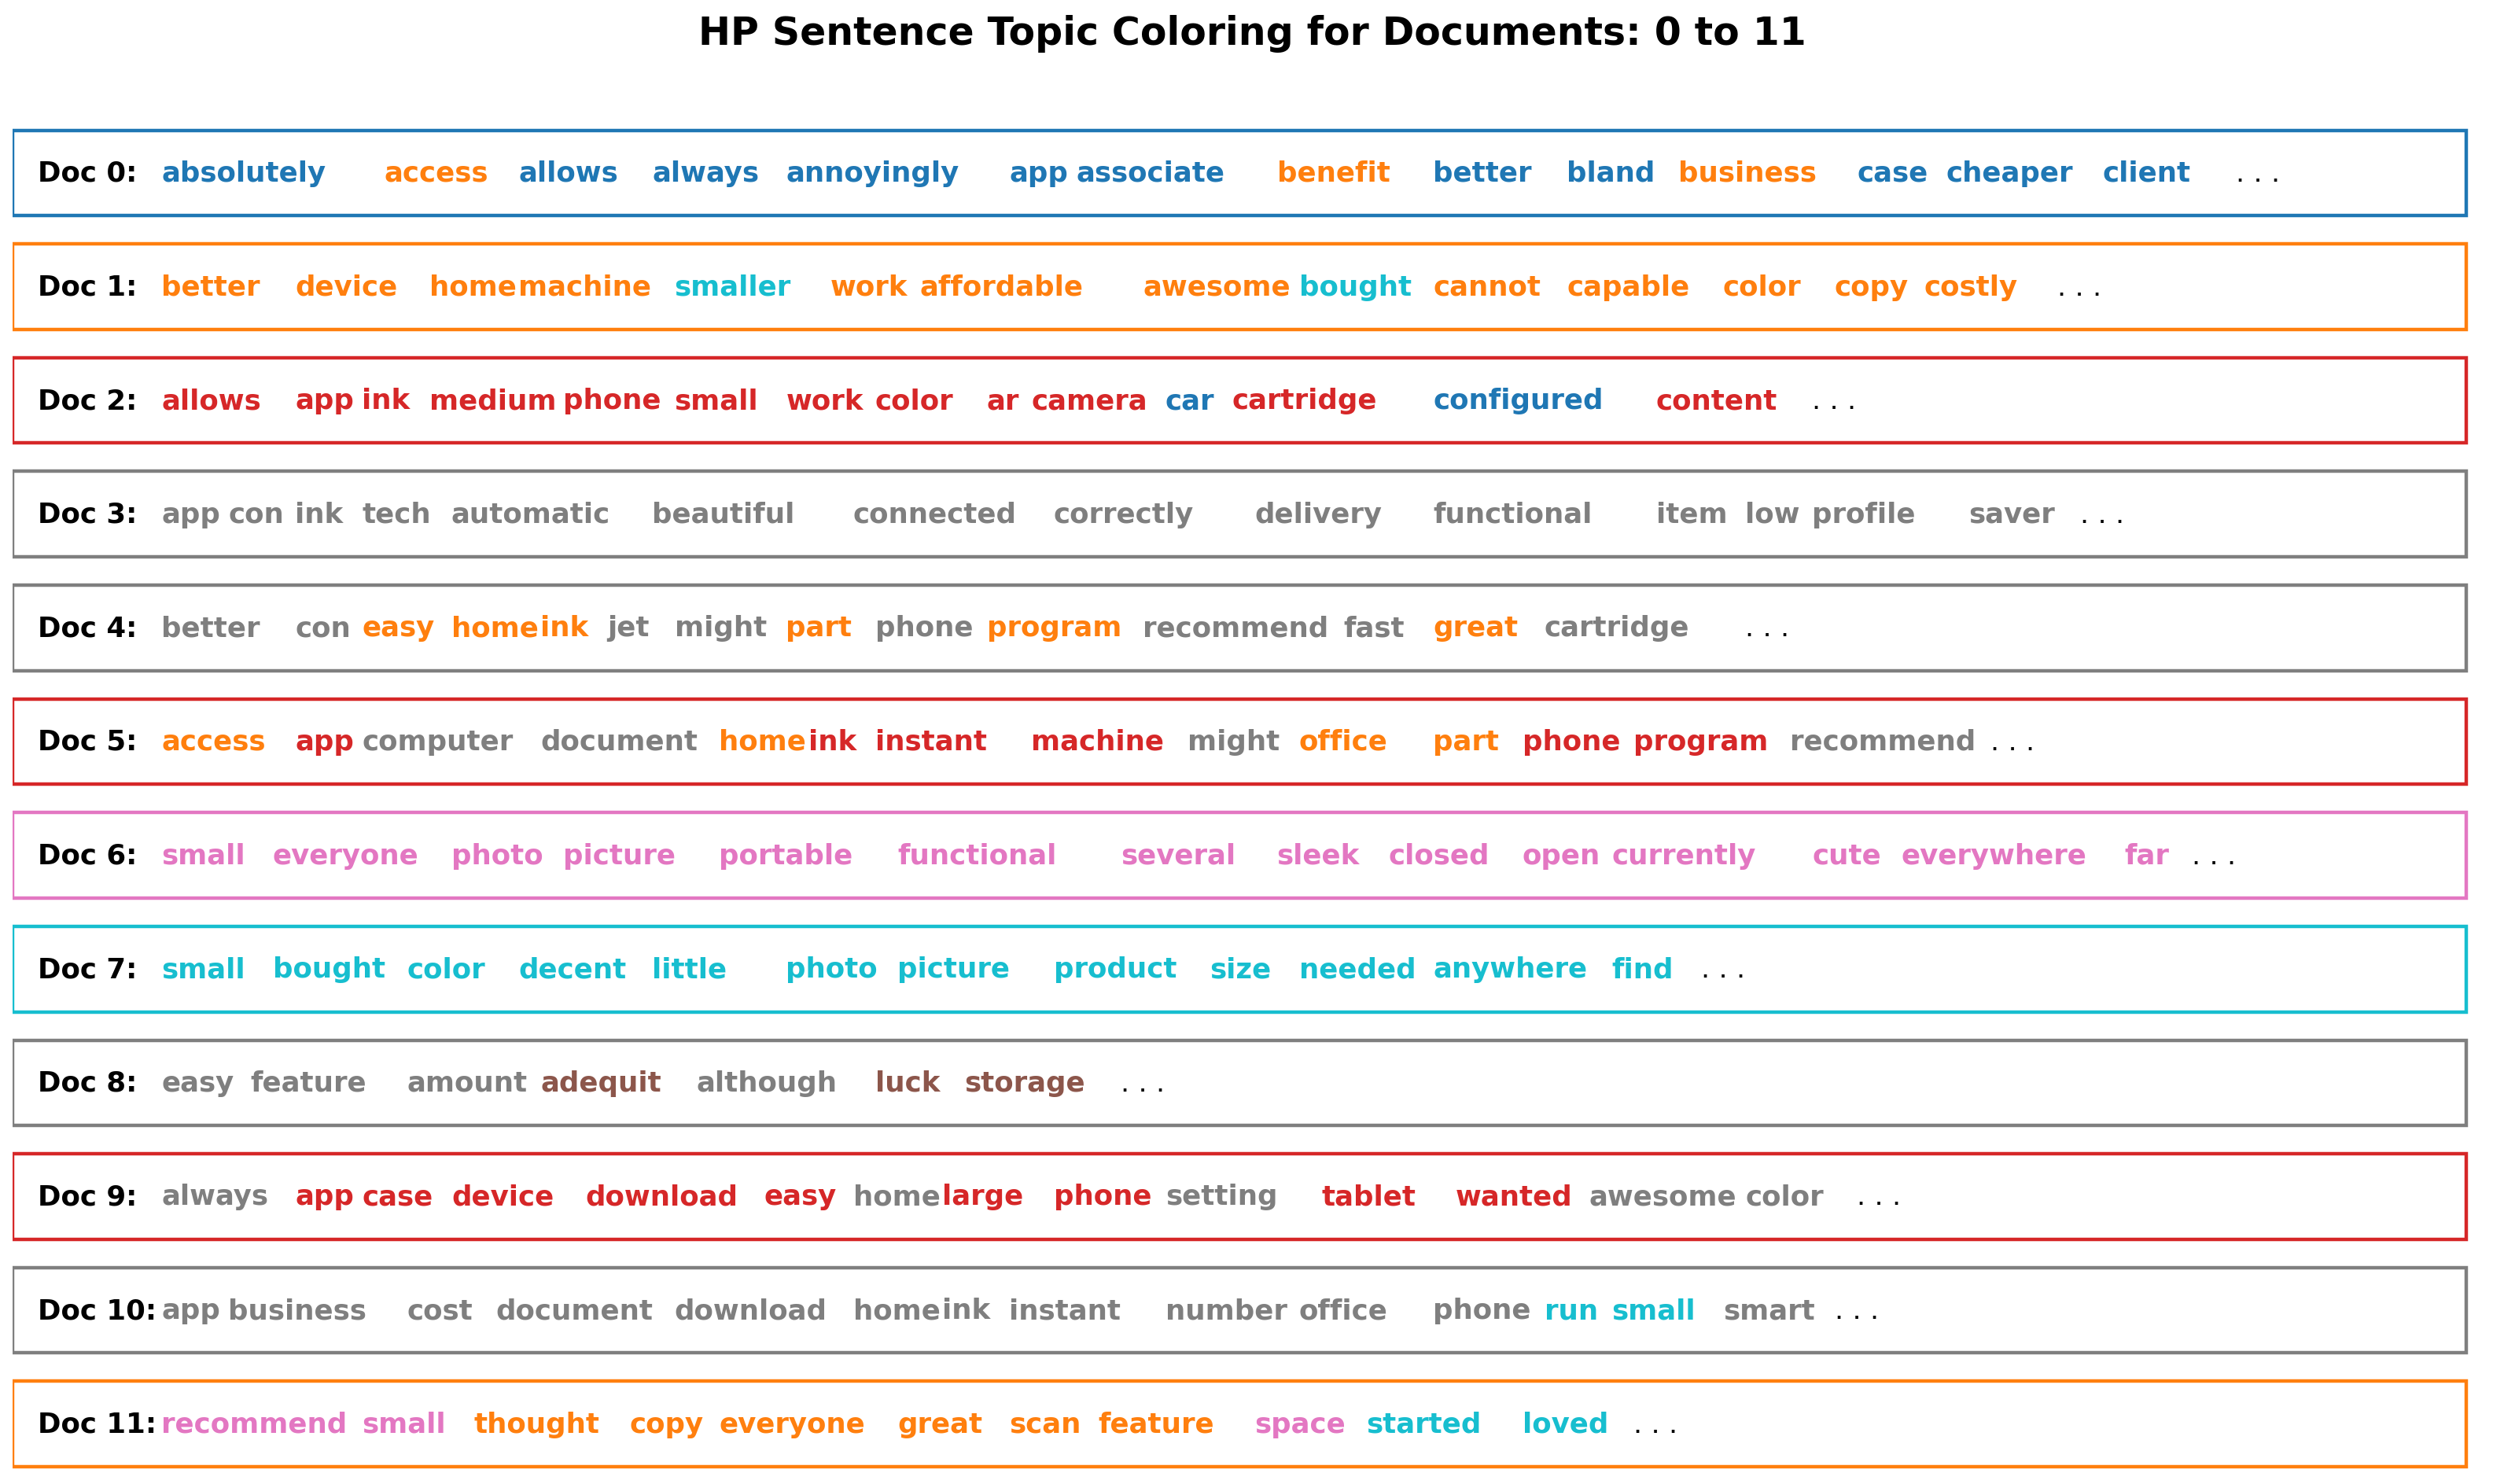

In [66]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model_hp, corpus=corpus_hp, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('HP Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

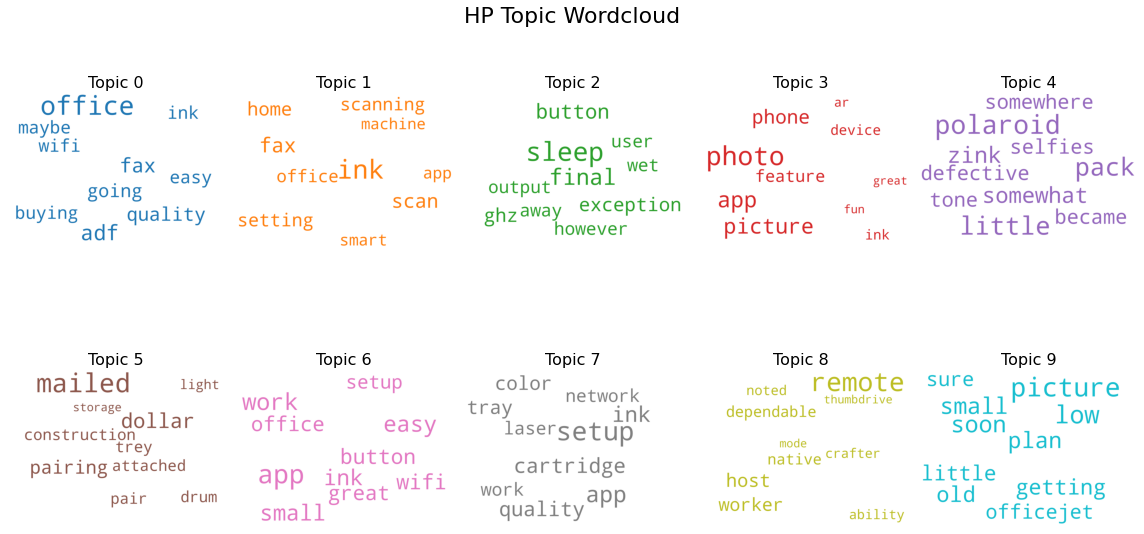

In [67]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_hp = lda_model_hp.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_hp[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.suptitle('HP Topic Wordcloud', fontsize=22,y=0.9)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [68]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics_hp, topic_percentages_hp = topics_per_document(model=lda_model_hp, corpus=corpus_hp, end=-1)            

# Distribution of Dominant Topics in Each Document
df_hp_1 = pd.DataFrame(dominant_topics_hp, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_hp = df_hp_1.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_hp = dominant_topic_in_each_doc_hp.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_hp = pd.DataFrame([dict(t) for t in topic_percentages_hp])
df_topic_weightage_by_doc_hp = topic_weightage_by_doc_hp.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words_hp = [(i, topic) for i, topics in lda_model_hp.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked_hp = pd.DataFrame(topic_top3words_hp, columns=['topic_id', 'words'])
df_top3words_hp = df_top3words_stacked_hp.groupby('topic_id').agg(', \n'.join)
df_top3words_hp.reset_index(level=0,inplace=True)

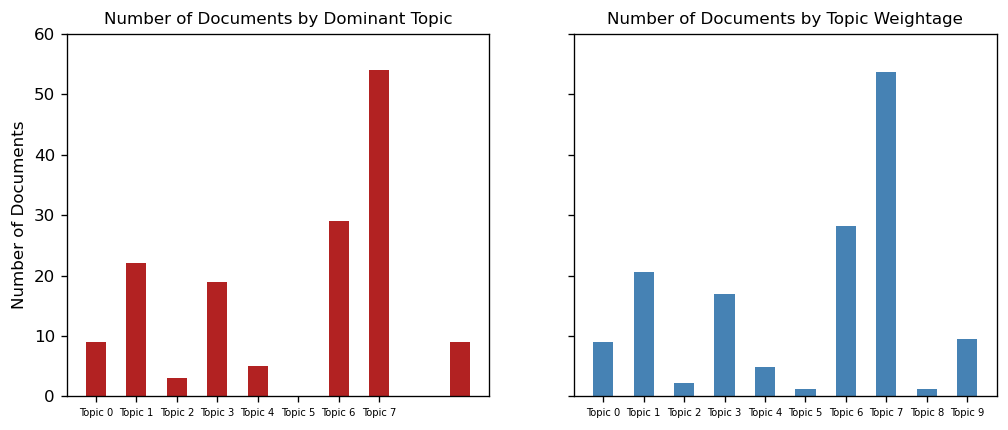

In [70]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_hp = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_hp, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc_hp.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter_hp)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(labelsize=6)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_hp, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_hp.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter_hp)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.xaxis.set_tick_params(labelsize=6)

plt.show()

# Canon Frequency Distribution in Document and Each Topic

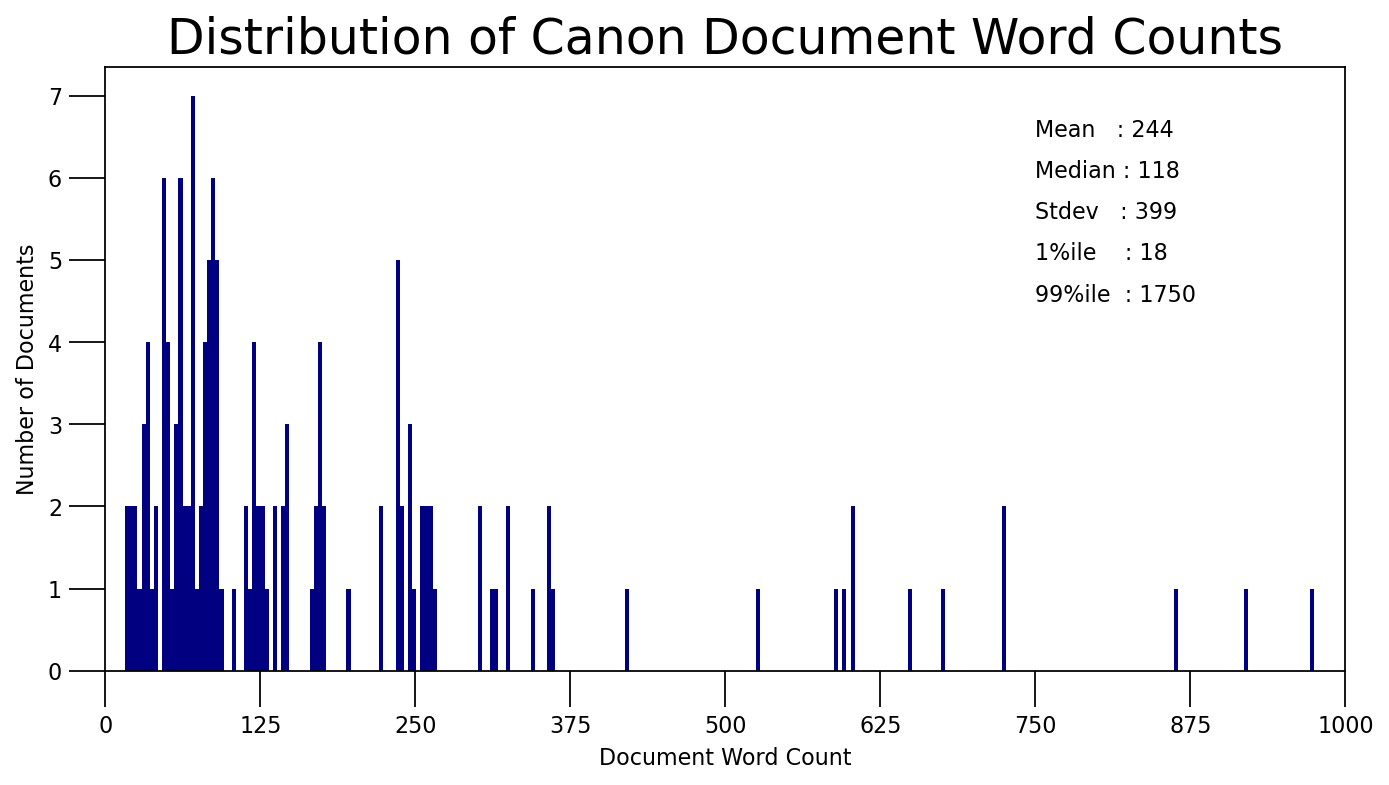

In [90]:
doc_lens_canon = [len(d) for d in df_dominant_topic_canon.Text]

# Plot
plt.figure(figsize=(10,5), dpi=160)
plt.hist(doc_lens_canon, bins = 1000, color='navy')
plt.text(750, 6.5, "Mean   : " + str(round(np.mean(doc_lens_canon))))
plt.text(750, 6, "Median : " + str(round(np.median(doc_lens_canon))))
plt.text(750, 5.5, "Stdev   : " + str(round(np.std(doc_lens_canon))))
plt.text(750, 5, "1%ile    : " + str(round(np.quantile(doc_lens_canon, q=0.01))))
plt.text(750, 4.5, "99%ile  : " + str(round(np.quantile(doc_lens_canon, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Canon Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Users\Kangping\AppData\Local\Temp/ipykernel_11168/1896561823.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_canon.loc[df_canon.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


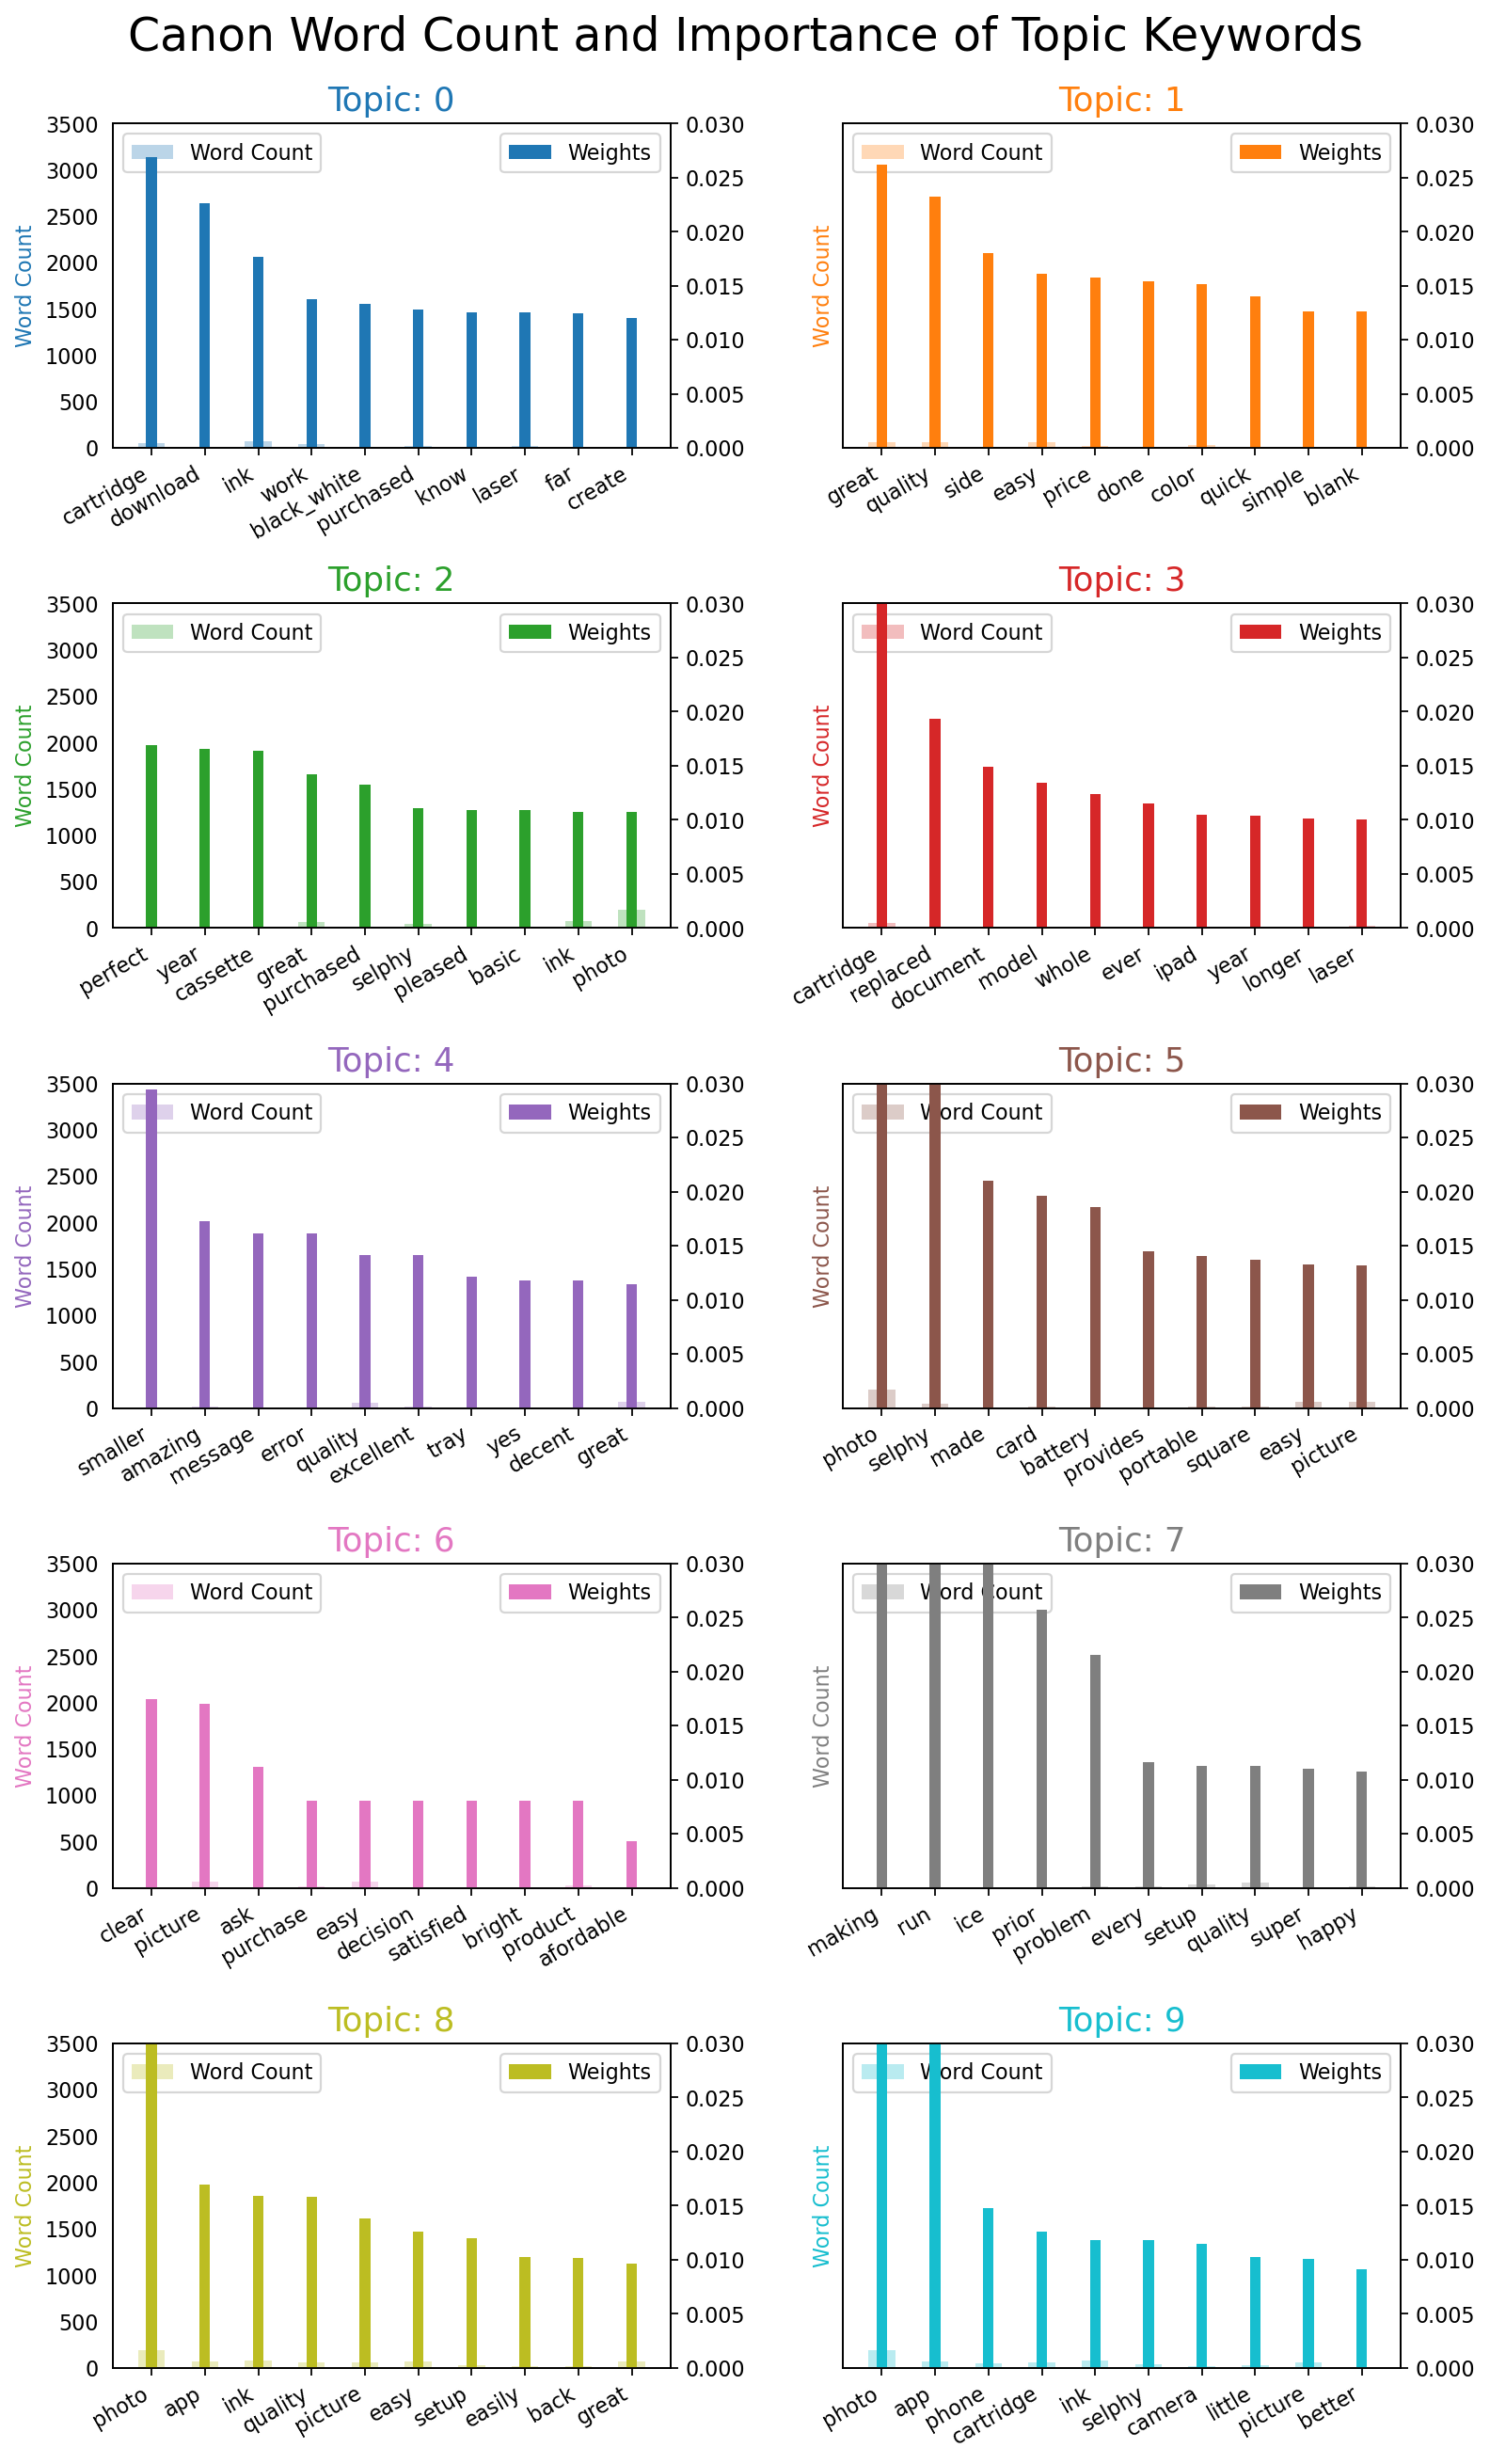

In [89]:
topics_canon = lda_model_canon.show_topics(formatted=False)
data_flat_canon = [w for w_list in words_canon for w in w_list]
counter_canon = Counter(data_flat_canon)

out = []
for i, topic in topics_canon:
    for word, weight in topic:
        out.append([word, i , weight, counter_canon[word]])

df_canon = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_canon.loc[df_canon.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_canon.loc[df_canon.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_canon.loc[df_canon.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Canon Word Count and Importance of Topic Keywords', fontsize=22, y=1.02)    
plt.show()

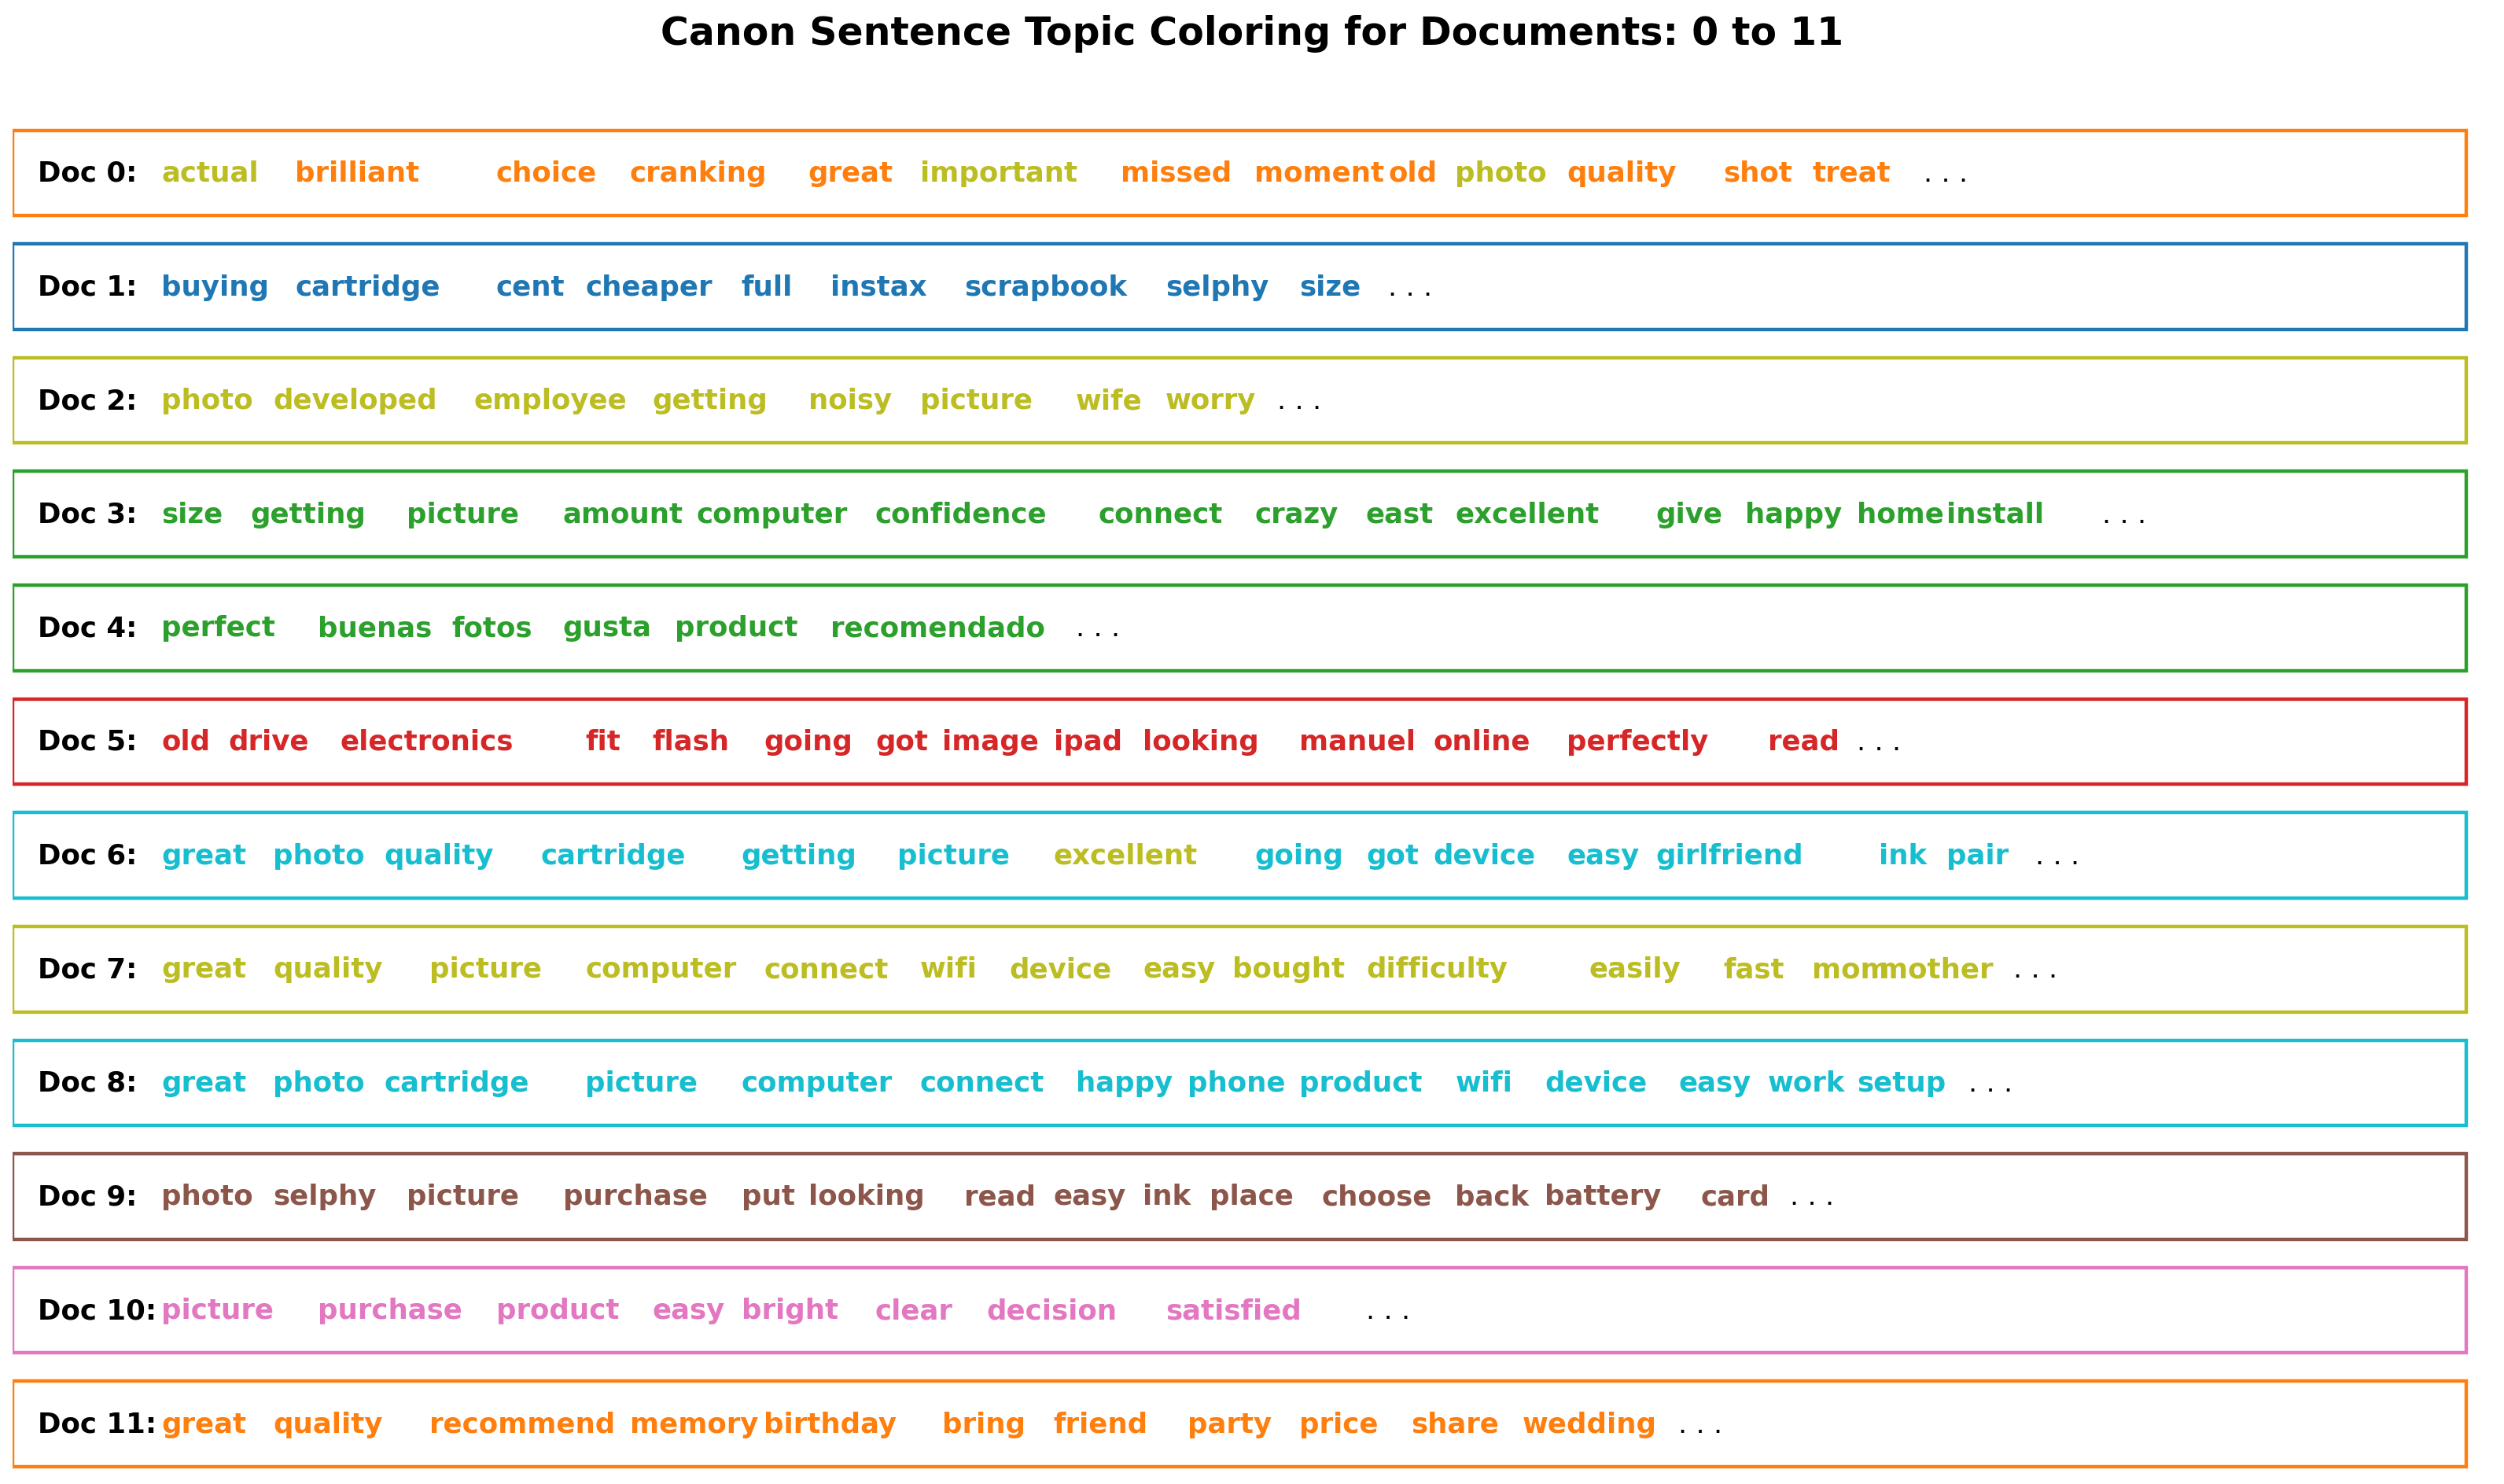

In [77]:
def sentences_chart(lda_model=lda_model_canon, corpus=corpus_canon, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Canon Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

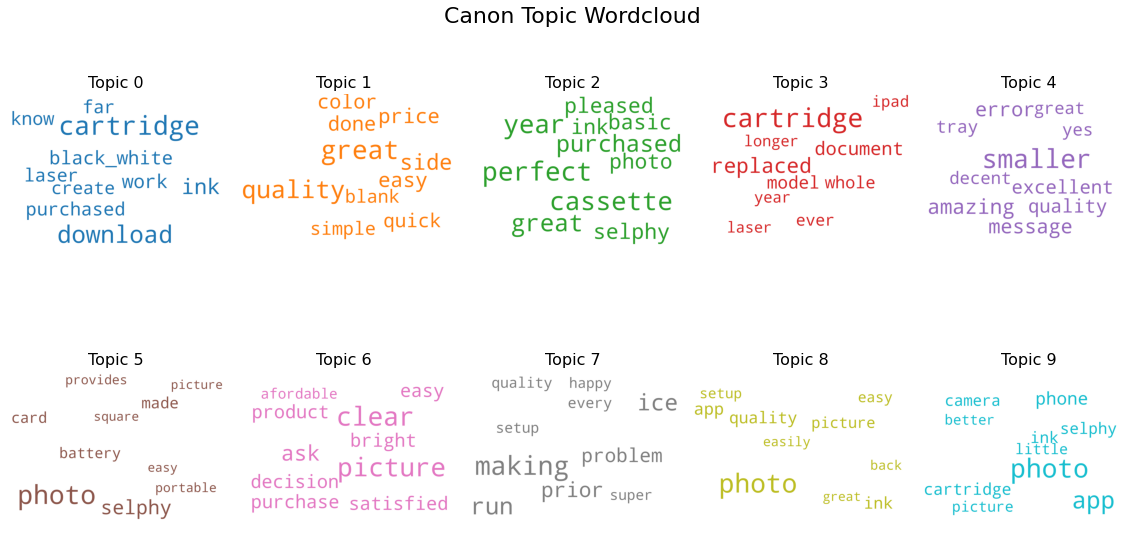

In [78]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_canon = lda_model_canon.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_canon[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.suptitle('Canon Topic Wordcloud', fontsize=22,y=0.9)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [79]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics_canon, topic_percentages_canon = topics_per_document(model=lda_model_canon, corpus=corpus_canon, end=-1)            

# Distribution of Dominant Topics in Each Document
df_canon_1 = pd.DataFrame(dominant_topics_canon, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_canon = df_canon_1.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_canon = dominant_topic_in_each_doc_canon.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_canon = pd.DataFrame([dict(t) for t in topic_percentages_canon])
df_topic_weightage_by_doc_canon = topic_weightage_by_doc_canon.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words_canon = [(i, topic) for i, topics in lda_model_canon.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked_canon = pd.DataFrame(topic_top3words_canon, columns=['topic_id', 'words'])
df_top3words_canon = df_top3words_stacked_canon.groupby('topic_id').agg(', \n'.join)
df_top3words_canon.reset_index(level=0,inplace=True)

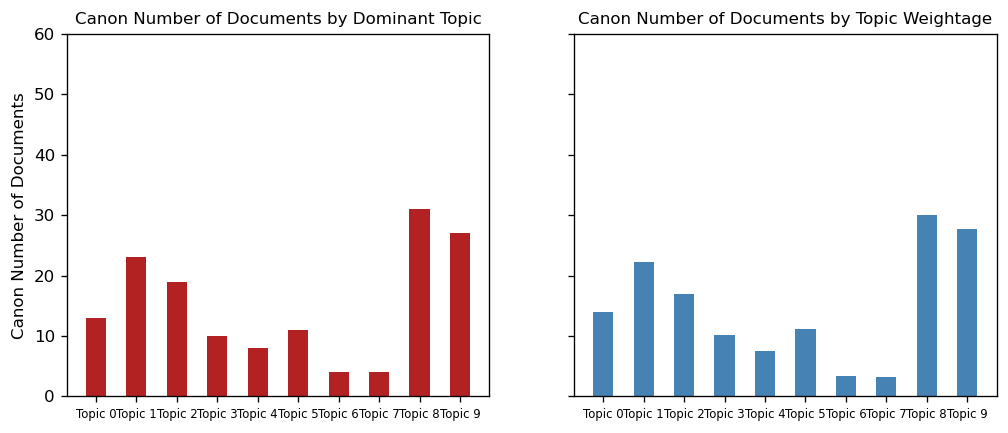

In [80]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_canon = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_canon, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc_canon.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter_canon)
ax1.set_title('Canon Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Canon Number of Documents')
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(labelsize=7)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_canon, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_canon.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter_canon)
ax2.set_title('Canon Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.xaxis.set_tick_params(labelsize=7)

plt.show()